In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np

### Models and Configs

In [2]:
import yaml

# Load YAML config
with open("config/model_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Unpack paths
paths = config["data_paths"]
gen_csv_path = paths["generator_csv"]
storage_csv_path = paths["storage_csv"]
demand_csv_path = paths["demand_csv"]
renewable_csv_path = paths["renewable_csv"]

# Unpack solver config
solver_cfg = config["solver"]
solver_name = solver_cfg["name"]
solver_exec = solver_cfg.get("executable")
solver_options = solver_cfg.get("options", {})

In [3]:
import sys
sys.path.append('./src')

from models.DAFOModel import DAFOModel
from models.RTSimModel import RTSimModel
from data_utils.DataProcessor import DataProcessor
from data_utils.extract_da import extract_da
from data_utils.results_processing import (
    calculate_rt_margins,
    calculate_rt_payoffs,
    calculate_system_metrics,
    calculate_premium_convergence,
    calculate_total_margins
)
from data_utils.scenario_generation import scenario_generation

### Process Data and Solve for DA

In [4]:
import os
os.makedirs("data/processed", exist_ok=True)

# Improved from 5.4 seconds to 0.3 seconds (for 5 scenarios)
scenario_generation(
    input_dir="data/raw/renewable",
    output_file="data/processed/renewable.csv",
    num_scenarios=5
)   

Aggregated data written to data/processed/renewable.csv


In [5]:
system_data = DataProcessor(gen_csv_path, storage_csv_path, demand_csv_path, renewable_csv_path)
pyomo_system_data = system_data.prepare_pyomo_data(config)

dafo_model = DAFOModel(config)
da_instance = dafo_model.create_instance(pyomo_system_data)

opt = pyo.SolverFactory(solver_name, executable=solver_exec)
result = opt.solve(da_instance, tee=solver_options.get("tee", False))

Generator data loaded: 5 of 157 generators loaded.
Storage data loaded: 0 of 22 storages loaded.
Demand data loaded: 2 of 8784 periods loaded.
Renewable data loaded: 2 of 24 periods loaded.


In [9]:
dataRT, total_da, df, demand, Energy, Prices, Gross_margins = extract_da(da_instance, pyomo_system_data)

RTsim = RTSimModel(config)

iRT = RTsim.create_instance(dataRT)
opt.solve(iRT)

# Calculate results using functions from results_processing
RTmargins = calculate_rt_margins(iRT, dataRT)
RTpayoffs = calculate_rt_payoffs(iRT, dataRT, df)
# Pass the extracted DA totals (total_da) here
Total = calculate_system_metrics(iRT, dataRT, total_da)
premium_convergence = calculate_premium_convergence(Gross_margins, RTpayoffs)
Total_margin = calculate_total_margins(iRT, dataRT, Gross_margins, RTmargins, RTpayoffs, premium_convergence, total_da)

with pd.ExcelWriter('results/results.xlsx') as writer:
    # Write each DataFrame to a different sheet
    RTmargins.to_excel(writer, sheet_name='RT Margins')
    RTpayoffs.to_excel(writer, sheet_name='RT Payoffs')
    Total.to_excel(writer, sheet_name='System Metrics')
    premium_convergence.to_excel(writer, sheet_name='Premium Convergence')
    Total_margin.to_excel(writer, sheet_name='Total Margins')
    df.to_excel(writer, sheet_name='FO Supply AWARDS')
    demand.to_excel(writer, sheet_name='FO Demand AWARDS')
    Energy.to_excel(writer, sheet_name='DA Energy')
    Prices.to_excel(writer, sheet_name='DA Prices')

print("Results have been written to 'results.xlsx'")

Results have been written to 'results.xlsx'


In [7]:
print("\nRT Margins:")
print(round(RTmargins, 2))

print("\nRT Payoffs:")
print(round(RTpayoffs, 2))

print("\nSystem Metrics:")
print(round(Total, 2))

print("\nPremium Convergence:")
print(round(premium_convergence, 2))

print("\nTotal Margins:")
print(round(Total_margin, 2))

print("\nFO Supply AWARDS:")
print(round(df, 2))

print("\nFO Demand AWARDS:")
print(round(demand, 2))

print("\nDA Energy:")
print(round(Energy, 2))

print("\nDA Prices (FO):")
print(round(Prices, 2))


RT Margins:
                    1      2    3    4    5
Generator Time                             
1         1     30.08  15.04  0.0 -0.0 -0.0
          2     30.08  15.04  0.0 -0.0 -0.0
2         1     30.00   0.00  0.0  0.0  0.0
          2     30.00   0.00  0.0  0.0  0.0
3         1      0.00   0.00  0.0  0.0  0.0
          2      0.00   0.00  0.0  0.0  0.0
4         1      0.00   0.00  0.0  0.0  0.0
          2      0.00   0.00  0.0  0.0  0.0
5         1      0.00   0.00  0.0  0.0  0.0
          2      0.00   0.00  0.0  0.0  0.0

RT Payoffs:
             UP1    UP2  UP3  UP4  DN2  DN3  DN4  DN5
Generator                                            
1         -60.16 -30.08 -0.0 -0.0  0.0  0.0  0.0  0.0
2         -60.00  -0.00  0.0  0.0  0.0 -0.0 -0.0 -0.0
3          -0.00   0.00  0.0  0.0 -0.0 -0.0 -0.0 -0.0
4           0.00   0.00  0.0  0.0 -0.0 -0.0 -0.0 -0.0
5           0.00   0.00  0.0  0.0 -0.0 -0.0 -0.0 -0.0

System Metrics:
                   DA       1       2    3     4   

# Visualisation

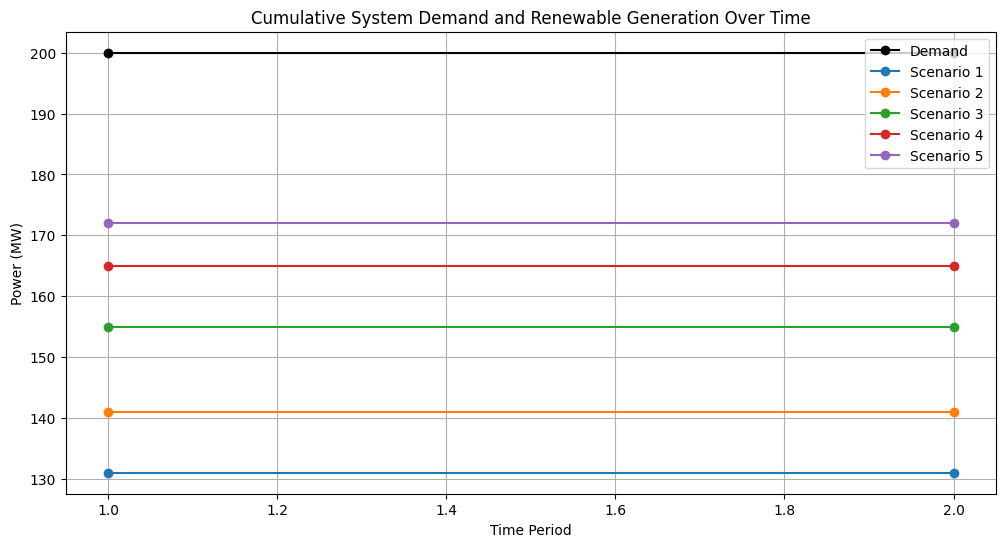

In [8]:
from data_utils.util_plotting import plot_demand_and_renewables
plot_demand_and_renewables(pyomo_system_data)